In [1]:
import glob
import os
import random
import shutil
import sys
from pathlib import Path

import numpy as np
import scipy.io
import torch

current_dir = os.path.dirname(os.path.abspath("__file__"))  # 当前目录
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))  # 上一级目录
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, ".."))  # 上两级目录
sys.path.append(grandparent_dir)

import data_function
import metrics
import tools
import utils
from ex_main.model import *
from ex_main.train_dataloader import getData
from utils.config_plot import *

In [2]:
ppath = "/home/hy/project/reid_task/ex_main/"

# Config
config_file_path = os.path.join(ppath, "config.py")
config = utils.common.read_config_file(config_file_path)

# Initialize a logger tool
logger = utils.logger.Logger(config.outputs_path)
logger.info("#" * 50)
logger.info(f"Task: {config.taskname}")
logger.info(f"Using device: {config.device}")
logger.info(f"Using data type: {config.dtype}")

# Set environment
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)
torch.cuda.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # The result cannot be reproduced when True

# Outputs path
vis_outputs_path = "./results/vis/"
if os.path.exists(vis_outputs_path):
    shutil.rmtree(vis_outputs_path)

2024-04-05 11:44:06 INFO ##################################################
2024-04-05 11:44:06 INFO Task: ReID_Task
2024-04-05 11:44:06 INFO Using device: cuda
2024-04-05 11:44:06 INFO Using data type: torch.float32


In [3]:
# Data
config.test_batch_size = 64
train_loader, query_loader, gallery_loader, num_classes = getData(config=config)

# Model
model = ReidNet(num_classes=num_classes, config=config, logger=logger).to(config.device)
path = os.path.join(ppath, "outputs/models/model_120.tar")
utils.network.load_network(model, path, config.device)
print("Model numbers of parameters: {}".format(utils.network.count_parameters(model)))

successfully load imagenet pre-trained resnet50-ibn model
Successfully loaded pretrained weights from "/home/hy/project/reid_task/ex_main/outputs/models/model_120.tar"
Model numbers of parameters: 33449024


In [4]:
def val_collate_fn(batch):
    imgs, pids, camids, impath = zip(*batch)
    return torch.stack(imgs, dim=0), pids, camids, impath


hmap_loader = query_loader
hmap_loader.collate_fn = val_collate_fn

final_feats = []
final_labels = []
for batch_idx, data in enumerate(hmap_loader):
    imgs, pids, camids, paths = data
    imgs = imgs.cuda()
    outputs = model.tsne(imgs)
    final_feats.append(outputs.cpu().detach().numpy())
    final_labels.append(pids)

final_feats = np.concatenate(final_feats)
final_labels = np.concatenate(final_labels)

In [5]:
from sklearn.manifold import TSNE

X = final_feats
X_embedded = TSNE(
    n_components=2,  perplexity=30
).fit_transform(X)
print(X_embedded)

[[ 38.229053    34.24109   ]
 [-54.927708    -2.9620235 ]
 [ 28.423368   -56.305824  ]
 ...
 [ 28.50453    -56.27963   ]
 [ -0.43464273  41.07631   ]
 [ -9.546687    33.180767  ]]


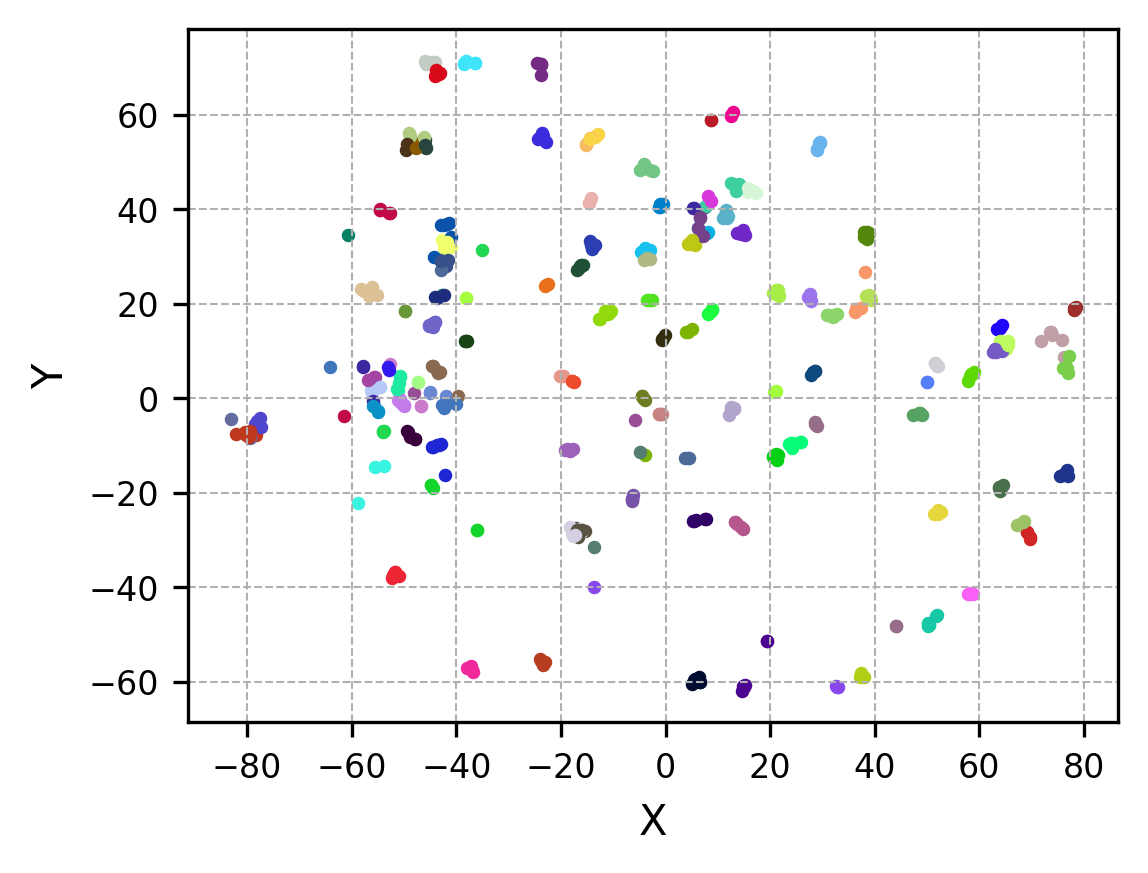

In [14]:
# Plot results
num_lines = 1
num_rows = 1
fig, axs = plt.subplots(
    num_lines, num_rows, figsize=(4 * num_rows, 3 * num_lines), dpi=300
)

subfig = axs
# subfig.set_title("(a)")
subfig.set_xlabel("X")
subfig.set_ylabel("Y")
colors = np.random.rand(len(final_labels), 3)
# for i in range(len(X_embedded)):
for i in range(len(X_embedded)):
    if  230<final_labels[i]:
        continue
    subfig.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[final_labels[i]], s=5)